# Проект: Исследовательский анализ продаж билетов на Яндекс Афише 

- Автор: Натэлла
- Дата: 14.07.2025

## Введение

### Цель проекта:

Проанализировать изменения пользовательского поведения и популярности мероприятий на сервисе Яндекс Афиша за период с июня по октябрь 2024 года. Выяснить, как изменился спрос осенью, какие события стали популярнее, как изменилась активность пользователей и какие площадки и партнёры стали лидерами.

### Задачи проекта:

- Загрузить и подготовить данные к анализу.
- Привести выручку к единой валюте (российские рубли).
- Проанализировать сезонную динамику заказов по типам мероприятий, устройствам и возрастным ограничениям.
- Изучить поведение пользователей осенью: количество заказов, DAU, средние чеки.
- Выделить популярные события, площадки и регионы.
- Проверить гипотезы о различии активности пользователей мобильных и стационарных устройств.
- Сформулировать рекомендации для команды Яндекс Афиши.


### Содержимое проекта
- [Шаг 1. Загрузка данных и знакомство с ними](#1-bullet)
- [Шаг 2. Предобработка данных и подготовка их к исследованию](#2-bullet)
- [Шаг 3. Исследовательский анализ данных](#3-bullet)
    - [Шаг 3.1. Анализ распределения заказов по сегментам и их сезонные изменения](#3.1-bullet)
    - [Шаг 3.2. Осенняя активность пользователей](#3.2-bullet)
    - [Шаг 3.3. Популярные события и партнёры](#3.3-bullet)
- [Шаг 4. Статистический анализ данных](#4-bullet)
- [Шаг 5. Общий вывод и рекомендации](#5-bullet)


<a id="1-bullet"></a>
## Шаг 1. Загрузка данных и и знакомство с ними

Начнём с загрузки библиотек и датасетов. Данные датасетов сохраним в виде датафремов.

In [104]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy import stats
from datetime import datetime
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

In [105]:
# Создаем датафрейм 
orders = pd.read_csv('./datasets/final_tickets_orders_df.csv')

# Выводим первые 5 строк датафрейма
display(orders.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [106]:
# Выводим информацию о датафрейме
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Датасет `final_tickets_orders_df.csv` содержит 14 столбцов и 290849 строк, в которых представлена информацияобо всех заказах билетов.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов представлены в едином виде удобном для дальнейшей работы.
- Столбцы с датами (`created_dt_msk`, `created_ts_msk`) необходимо привести к формату `datetime64`, чтобы использовать их для временного анализа.
- Размерность числовых данных в дальнейшей работе можно оптимизировать.  
- Столбец `days_since_prev` содержит пропуски (`NaN`) — это ожидаемо, так как у части пользователей нет предыдущих заказов. Остальные столбцы не содержат пропусков.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [107]:
# Создаем датафрейм 
events = pd.read_csv('./datasets/final_tickets_events_df.csv')

# Выводим первые 5 строк датафрейма
display(events.head())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [108]:
# Выводим информацию о датафрейме
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Датасет `final_tickets_events_df.csv` содержит 11 столбцов и 22427 строк, в которых представлена информация о мероприятиях, доступных для бронирования на Яндекс Афише с июня по октябрь 2024 года.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов представлены в едином виде удобном для дальнейшей работы.
- Размерность числовых данных в дальнейшей работе можно оптимизировать.  
- Столбцы не содержат пропусков.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [109]:
# Создаем датафрейм 
tenge = pd.read_csv('./datasets/final_tickets_tenge_df.csv')

# Выводим первые 5 строк датафрейма
display(tenge.head())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [110]:
# Выводим информацию о датафрейме
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Датасет `final_tickets_tenge_df.csv` содержит 4 столбца и 357 строк, в которых представлена информация о курс тенге к рублю за 2024 год.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов представлены в едином виде удобном для дальнейшей работы.
- Столбец `data` содержит дату и требует преобразования в формат `datetime64`, чтобы корректно использовать его при объединении с заказами.
- Размерность числовых данных в дальнейшей работе можно оптимизировать.  
- Cтолбцы не содержат пропусков.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

**Промежуточный вывод:**

Корректность и структура:
- Все три датасета успешно загружены, пропуски обнаружены только в столбце `days_since_prev` — это ожидаемо, так как не у всех пользователей есть предыдущие заказы.
- Типы данных требуют оптимизации:
  - Столбцы с датами (`created_dt_msk`, `created_ts_msk`, `data`) представлены как `object` и требуют преобразования в `datetime64`.
  - Некоторые числовые столбцы (`order_id`, `age_limit`, `tickets_count`) можно привести к более компактным типам (`int32`, `int16`, `int8`).
- Значения в столбцах соответствуют описанию, структура таблиц логична и пригодна для объединения.

План действий на этапе предобработки:
1. Преобразовать типы данных (даты, числовые ID).
2. Объединить датасеты:
   - `orders` и `events` — по `event_id`;
   - `orders` и `tenge` — по дате, если валюта — `kzt`.
3. Рассчитать дополнительные признаки:
   - `revenue_rub` — выручка в рублях;
   - `one_ticket_revenue_rub` — средняя выручка за билет;
   - `month` и `season` — для анализа временных паттернов.
4. Проверить данные на выбросы и аномалии в `revenue`, `tickets_count`.
5. Проверить на дубликаты — как явные, так и логические.

<a id="2-bullet"></a>
## Шаг 2. Предобработка данных и подготовка их к исследованию

Пред общей предобработкой объеденим все датафремы, чтобы затем проводить предобработку уже на полном наборе данных.

In [111]:
# Объединяем по event_id
orders_full = orders.merge(events, on='event_id', how='left')

# Выполним проверку объединения
orders_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

На выходе получен датафрейм `orders_full` с 290 849 строками и 24 столбцами. Из них:
- первые 14 столбцов — из таблицы заказов;
- оставшиеся 10 — из таблицы мероприятий.

Мы видим, что некоторые значения из events не подтянулись:
- `event_type_main` - 290611 non-null;
- `region_name` - 290611 non-null;
- и др.

То есть 238 заказов (~0.08%) не нашли подходящее событие в таблице events. Это может быть:
- артефакт фильтрации в SQL;
- или данные в заказах ссылаются на уже удалённое или исключённое событие.

In [112]:
# Преобразуем даты
orders_full['created_dt_msk'] = pd.to_datetime(orders_full['created_dt_msk'])
orders_full['created_ts_msk'] = pd.to_datetime(orders_full['created_ts_msk'])
tenge['data'] = pd.to_datetime(tenge['data'])

# Объединение по дате заказа
orders_full = orders_full.merge(
    tenge[['data', 'curs']],
    how='left',
    left_on='created_dt_msk',
    right_on='data'
)

# Расчёт выручки в рублях
orders_full['revenue_rub'] = np.where(
    orders_full['currency_code'] == 'kzt',
    orders_full['revenue'] * (orders_full['curs'] / 100),
    orders_full['revenue']
)

# Удаление лишнего столбца
orders_full.drop(columns='data', inplace=True)

# Проверка итоговой структуры
orders_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

Изучим столбцы с категориальными данными. Проверим, встречаются ли значения, которые могут обозначать пропуски в данных или отсутствие информации.

In [113]:
# Выделим категориальные столбцы:
cat_cols = orders_full.select_dtypes(include='object').columns.tolist()

# Изучим уникальные значения и потенциальные пропуски:
for col in cat_cols:
    print(f"\n🔎 {col}:")
    print(orders_full[col].value_counts(dropna=False).head(20))


🔎 user_id:
user_id
0beb8fc0c0a9ce1    10258
18e9aead0a393e7     4368
8187dac4be757a0     4061
3ee7dc2e115847f     3833
7eb4fc207ecc10f     3751
1c2a2133e1df1b4     3539
4ec8f6429431987     3413
ad2dc32364ed948     3279
b54dd0cd81121fc     3164
cdbc02c6ad8087a     3072
02ea4583333f064     3008
8d6c1ff89fac35f     2882
7d22e22c99ec66e     2648
fe237d2cfd6e503     2431
44c1c640a242aea     2331
2c8092b69b753cc     2052
efd7b595af23463     1647
fc950d43881de43     1586
6cf5aff356429e5     1571
96368e5714d1673     1531
Name: count, dtype: int64

🔎 cinema_circuit:
cinema_circuit
нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: count, dtype: int64

🔎 currency_code:
currency_code
rub    285780
kzt      5069
Name: count, dtype: int64

🔎 device_type_canonical:
device_type_canonical
mobile     232679
desktop     58170
Name: count, dtype: int64

🔎 service_name:
service_name
Билеты без проблем        63709
Лови билет

Как мы отметили ранее, при просоединении датафрейма events к orders, некоторые значения из events не подтянулись, что может быть связано с ошибкой фильтрации в SQL или данные в заказах ссылаются на уже удалённое или исключённое событие. 

Все остальны категориальные столбцы содержат полные данные, без пропусков и отсутвия информации и подходят для дальнейшего анализа. 

In [114]:
# Найдём строки, в которых пропуски есть во всех столбцах из events
missing_cols = orders_full.columns[
    (orders_full.isna().sum() > 0) & (orders_full.columns != 'days_since_prev')
]

# Отфильтруем строки, где ВСЕ эти колонки равны NaN
rows_with_missing = orders_full[orders_full[missing_cols].isna().all(axis=1)]

print(rows_with_missing.info())

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 62 to 287281
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                238 non-null    int64         
 1   user_id                 238 non-null    object        
 2   created_dt_msk          238 non-null    datetime64[ns]
 3   created_ts_msk          238 non-null    datetime64[ns]
 4   event_id                238 non-null    int64         
 5   cinema_circuit          238 non-null    object        
 6   age_limit               238 non-null    int64         
 7   currency_code           238 non-null    object        
 8   device_type_canonical   238 non-null    object        
 9   revenue                 238 non-null    float64       
 10  service_name            238 non-null    object        
 11  tickets_count           238 non-null    int64         
 12  total                   238 non-null    float64    

Так как, строк с пропусками не много (238 строк, что примерно 0,08% от общего количества данных) удалим их из датаврема, чтобы данные значения не влияли на дальнейший анализ даннах.  

In [115]:
# Подсчитаем количество строк до предобработки
before = orders_full.shape[0]

# Удалим строки с пропусками
orders_full = orders_full.drop(rows_with_missing.index)

after = orders_full.shape[0]

orders_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290611 entries, 0 to 290848
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611 non-

Мы удалили строки с пропусками в категориальных данных и теперь приступим к проверке количесвенных данных. Посмотрим на распредление и наличие выбросов. 

In [116]:
# Разделение на подмножества по валюте
orders_rub = orders_full[orders_full["currency_code"] == "rub"]
orders_kzt = orders_full[orders_full["currency_code"] == "kzt"]

# Статистика по revenue и tickets_count
print("Статистика по revenue (rub):")
print(orders_rub['revenue'].describe())

print("\nСтатистика по revenue (kzt):")
print(orders_kzt['revenue'].describe())

print("\nСтатистика по tickets_count (rub):")
print(orders_rub['tickets_count'].describe())

print("\nСтатистика по tickets_count (kzt):")
print(orders_kzt['tickets_count'].describe())

Статистика по revenue (rub):
count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

Статистика по revenue (kzt):
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

Статистика по tickets_count (rub):
count    285542.000000
mean          2.754159
std           1.171575
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Статистика по tickets_count (kzt):
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


Анализ revenue (выручка):
- RUB:
    - Среднее значение: ~548 руб.
    - Максимум: более 81 000 руб. — это очень вероятный выброс.
    - Стандартное отклонение: большое — почти 872.
    - Минимум: отрицательное значение (−90.76) — скорее всего, это возврат или ошибка.

 Вывод: есть как минимум один явный выброс (отрицательные значения), и много заказов с необычно высокой выручкой.

- KZT:
    - Среднее значение: ~4995 тенге.
    - Максимум: ~26 425 тенге.
    - Нулевая выручка присутствует — потенциально это брони без оплаты или тестовые записи.

 Вывод: здесь нет отрицательных значений, но тоже возможны выбросы по верхнему краю.

Анализ tickets_count (количество билетов):
- RUB:
    - Max = 57 — возможно, это ошибка или корпоративная закупка.

- KZT:
    - Max = 6 — выглядит более реалистично.

 Вывод: данные по рублям включают больше аномальных значений.

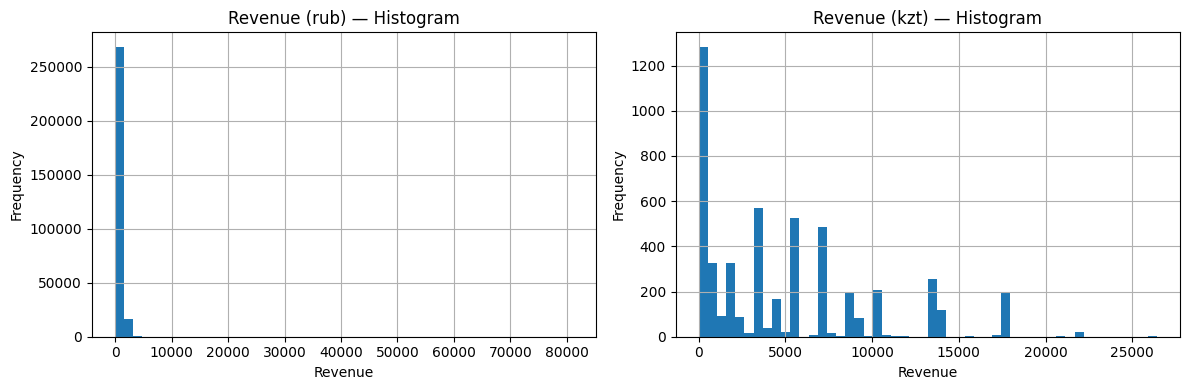

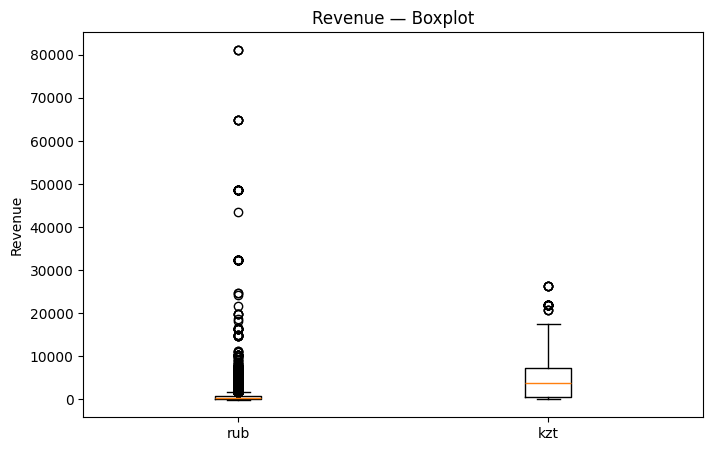

In [117]:
# Гистограмма revenue
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
orders_rub['revenue'].hist(bins=50)
plt.title('Revenue (rub) — Histogram')
plt.xlabel('Revenue')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
orders_kzt['revenue'].hist(bins=50)
plt.title('Revenue (kzt) — Histogram')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot revenue
plt.figure(figsize=(8, 5))
plt.boxplot([orders_rub['revenue'], orders_kzt['revenue']], tick_labels=['rub', 'kzt'])
plt.title('Revenue — Boxplot')
plt.ylabel('Revenue')
plt.show()



In [118]:
# RUB
q1_rub = orders_rub['revenue'].quantile(0.25)
q3_rub = orders_rub['revenue'].quantile(0.75)
iqr_rub = q3_rub - q1_rub
upper_bound_rub = q3_rub + 1.5 * iqr_rub

print("📊 Выбросы в revenue (RUB):")
print(f"Q1: {q1_rub:,.2f}")
print(f"Q3: {q3_rub:,.2f}")
print(f"IQR: {iqr_rub:,.2f}")
print(f"Верхняя граница выбросов: {upper_bound_rub:,.2f}")

outliers_rub = orders_rub[orders_rub['revenue'] > upper_bound_rub]
print(f"Количество выбросов: {len(outliers_rub):,}")
print(f"Процент выбросов: {len(outliers_rub) / len(orders_rub) * 100:.2f}%")

# KZT 
q1_kzt = orders_kzt['revenue'].quantile(0.25)
q3_kzt = orders_kzt['revenue'].quantile(0.75)
iqr_kzt = q3_kzt - q1_kzt
upper_bound_kzt = q3_kzt + 1.5 * iqr_kzt

print("\n📊 Выбросы в revenue (KZT):")
print(f"Q1: {q1_kzt:,.2f}")
print(f"Q3: {q3_kzt:,.2f}")
print(f"IQR: {iqr_kzt:,.2f}")
print(f"Верхняя граница выбросов: {upper_bound_kzt:,.2f}")

outliers_kzt = orders_kzt[orders_kzt['revenue'] > upper_bound_kzt]
print(f"Количество выбросов: {len(outliers_kzt):,}")
print(f"Процент выбросов: {len(outliers_kzt) / len(orders_kzt) * 100:.2f}%")

📊 Выбросы в revenue (RUB):
Q1: 114.17
Q3: 793.32
IQR: 679.15
Верхняя граница выбросов: 1,812.05
Количество выбросов: 10,162
Процент выбросов: 3.56%

📊 Выбросы в revenue (KZT):
Q1: 518.10
Q3: 7,397.66
IQR: 6,879.56
Верхняя граница выбросов: 17,717.00
Количество выбросов: 29
Процент выбросов: 0.57%


**Выручка с заказа — `revenue`**

- Валюта - RUB
    - Распределение: сильно скошено вправо. Большинство заказов — с низкой выручкой, но присутствуют экстремальные значения до 80 000 ₽.
    -  Вывод: выбросов немного (до 5%), однако они могут искажать статистику и графики. Рекомендуется ограничить анализ по 99-му перцентилю или границе выбросов.

- Валюта - KZT
    - Распределение: также скошено вправо, но меньше, чем в RUB. Более "чистое" распределение.
    - Вывод: выбросов крайне мало — можно использовать данные без фильтрации.

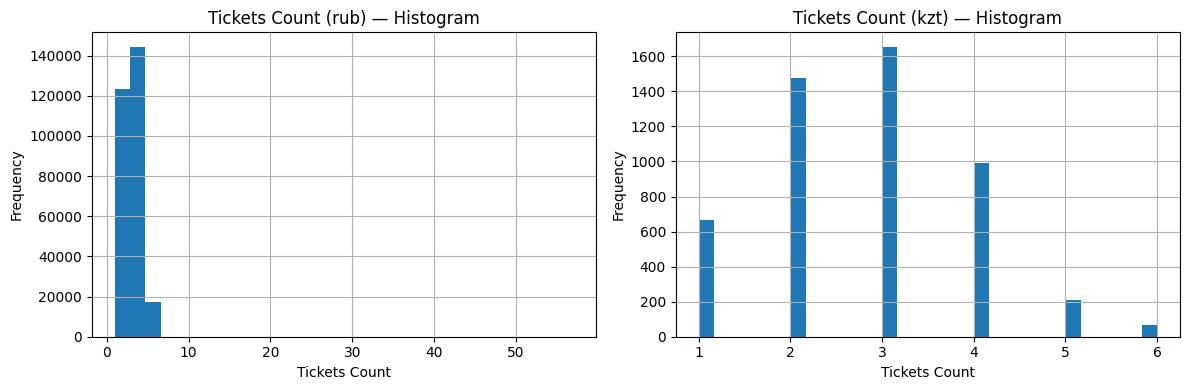

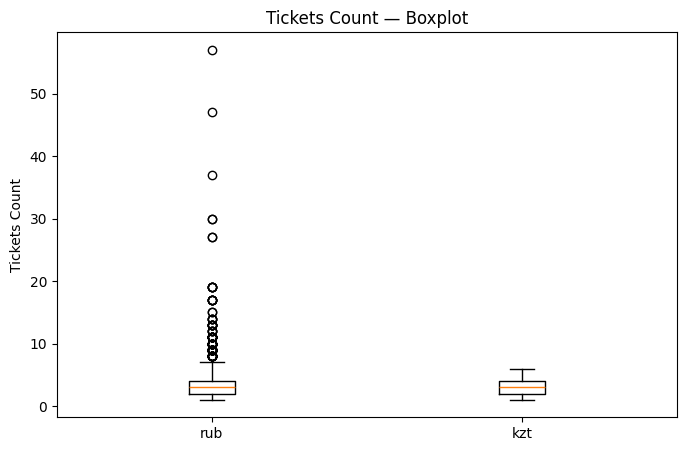

In [119]:
# Гистограмма tickets_count
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
orders_rub['tickets_count'].hist(bins=30)
plt.title('Tickets Count (rub) — Histogram')
plt.xlabel('Tickets Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
orders_kzt['tickets_count'].hist(bins=30)
plt.title('Tickets Count (kzt) — Histogram')
plt.xlabel('Tickets Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot tickets_count
plt.figure(figsize=(8, 5))
plt.boxplot([orders_rub['tickets_count'], orders_kzt['tickets_count']], tick_labels=['rub', 'kzt'])
plt.title('Tickets Count — Boxplot')
plt.ylabel('Tickets Count')
plt.show()

In [120]:
# RUB
q1_rub = orders_rub['tickets_count'].quantile(0.25)
q3_rub = orders_rub['tickets_count'].quantile(0.75)
iqr_rub = q3_rub - q1_rub
upper_bound_rub = q3_rub + 1.5 * iqr_rub

print("📊 Выбросы в tickets_count (RUB):")
print(f"Q1: {q1_rub:,.2f}")
print(f"Q3: {q3_rub:,.2f}")
print(f"IQR: {iqr_rub:,.2f}")
print(f"Верхняя граница выбросов: {upper_bound_rub:,.2f}")

outliers_rub = orders_rub[orders_rub['tickets_count'] > upper_bound_rub]
print(f"Количество выбросов: {len(outliers_rub):,}")
print(f"Процент выбросов: {len(outliers_rub) / len(orders_rub) * 100:.2f}%")

# KZT 
q1_kzt = orders_kzt['tickets_count'].quantile(0.25)
q3_kzt = orders_kzt['tickets_count'].quantile(0.75)
iqr_kzt = q3_kzt - q1_kzt
upper_bound_kzt = q3_kzt + 1.5 * iqr_kzt

print("\n📊 Выбросы в tickets_count (KZT):")
print(f"Q1: {q1_kzt:,.2f}")
print(f"Q3: {q3_kzt:,.2f}")
print(f"IQR: {iqr_kzt:,.2f}")
print(f"Верхняя граница выбросов: {upper_bound_kzt:,.2f}")

outliers_kzt = orders_kzt[orders_kzt['tickets_count'] > upper_bound_kzt]
print(f"Количество выбросов: {len(outliers_kzt):,}")
print(f"Процент выбросов: {len(outliers_kzt) / len(orders_kzt) * 100:.2f}%")

📊 Выбросы в tickets_count (RUB):
Q1: 2.00
Q3: 4.00
IQR: 2.00
Верхняя граница выбросов: 7.00
Количество выбросов: 126
Процент выбросов: 0.04%

📊 Выбросы в tickets_count (KZT):
Q1: 2.00
Q3: 4.00
IQR: 2.00
Верхняя граница выбросов: 7.00
Количество выбросов: 0
Процент выбросов: 0.00%


**Количество билетов в заказе — `tickets_count`**

- Валюта - RUB
    - Распределение: выбросов немного (до 5%), однако они могут искажать статистику и графики. Рекомендуется ограничить анализ по 99-му перцентилю или границе выбросов.
    - Вывод: выбросов крайне мало, и они обусловлены редкими случаями групповых покупок. Удаление — необязательно.

- Валюта - KZT
    - Распределение: также скошено вправо, но меньше, чем в RUB. Более "чистое" распределение.
    - Вывод: данных по tickets_count в KZT можно использовать напрямую — они полностью "чистые".

In [121]:
# Определение порогов по 99-му перцентилю
rub_99 = orders_rub['revenue'].quantile(0.99)
kzt_99 = orders_kzt['revenue'].quantile(0.99)

# Фильтрация данных
orders_rub_filtered = orders_rub[orders_rub['revenue'] <= rub_99]
orders_kzt_filtered = orders_kzt[orders_kzt['revenue'] <= kzt_99]

# Проверка результата
print(f"До фильтрации (RUB): {len(orders_rub)}")
print(f"После фильтрации (RUB): {len(orders_rub_filtered)}")
print(f"Удалено: {len(orders_rub) - len(orders_rub_filtered)} записей\n")

print(f"До фильтрации (KZT): {len(orders_kzt)}")
print(f"После фильтрации (KZT): {len(orders_kzt_filtered)}")
print(f"Удалено: {len(orders_kzt) - len(orders_kzt_filtered)} записей")

До фильтрации (RUB): 285542
После фильтрации (RUB): 282742
Удалено: 2800 записей

До фильтрации (KZT): 5069
После фильтрации (KZT): 5040
Удалено: 29 записей


In [122]:
# Объединение отфильтрованных данных
orders_full_filtered = pd.concat([orders_rub_filtered, orders_kzt_filtered])

# Количество строк после фильтрации выбросов
after_filtered = orders_full_filtered.shape[0]

print(f"До предобработки: {before} строк")
print(f"После строк с пропусками: {after} строк")
print(f"После фильтрации: {after_filtered} строк")
print(f"Удалено строк с пропусками: {before - after}")
print(f"Удалено выбросов: {after - after_filtered}")
print(f"Всего удалено: {before - after_filtered}")

До предобработки: 290849 строк
После строк с пропусками: 290611 строк
После фильтрации: 287782 строк
Удалено строк с пропусками: 238
Удалено выбросов: 2829
Всего удалено: 3067


Мы выполнили фильтрацию данных, притупим к анализу дубликатов.

In [123]:
# Явные дубликаты по всем столбцам
full_duplicates = orders_full_filtered.duplicated().sum()
print(f'Количество полных дубликатов строк: {full_duplicates}')

Количество полных дубликатов строк: 0


In [124]:
# Проверка дубликатов по идентификатору заказа
order_id_duplicates = orders_full_filtered['order_id'].duplicated().sum()
print(f'Количество дубликатов по order_id: {order_id_duplicates}')

Количество дубликатов по order_id: 0


Полных дубликатов и дубликатов по order_id не было найдено. 

Выполним поиск неявных дубликатов бронирований, т.е. когда один и тот же пользователь в один и тот же день оформляет идентичные по содержанию заказы, но с разными `order_id`.

In [125]:
# Получим список всех столбцов, кроме order_id
cols_except_order_id = [col for col in orders_full_filtered.columns if col != 'order_id']

# Проверим дубликаты по этим столбцам
duplicates_except_order_id = orders_full_filtered.duplicated(subset=cols_except_order_id).sum()
print(f'Количество дубликатов по всем признакам, кроме order_id: {duplicates_except_order_id}')

Количество дубликатов по всем признакам, кроме order_id: 30


In [126]:
dupes_df = orders_full_filtered[orders_full_filtered.duplicated(subset=cols_except_order_id, keep=False)]
display(dupes_df.sort_values(by='user_id'))

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,curs,revenue_rub
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",18.8553,69.82
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",18.8553,69.82
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",19.9516,11.23
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",19.9516,11.23
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",18.8012,59.19
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",18.8012,59.19
148473,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",19.9266,26.96
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",19.9266,26.96
156213,6657937,7eb4fc207ecc10f,2024-10-26,2024-10-26 09:39:03,418836,нет,0,rub,mobile,294.85,...,другое,№1703,Тепляковская область,Горнодолинск,43.0,4481.0,"Школа сценического мастерства ""Вдох"" Лтд","пер. Полярный, д. 87",19.9266,294.85
154993,3463819,7eb4fc207ecc10f,2024-09-21,2024-09-21 11:43:58,448579,нет,0,rub,mobile,2.54,...,спорт,№1622,Североярская область,Озёрск,2.0,4607.0,"Команда артистов ""Светлячок"" Лимитед","пер. Невского, д. 72",19.3316,2.54


Дубликаты абсолютно идентичны по всем признакам кроме `order_id`.

В многих случаях `created_ts_msk` совпадает до секунды - это говорит о том, что заказ на один и тот же билет был оформлен несколько раз, возможно по технической ошибке.

Так как дубликаты могут влиять на  дальнейший анлиз данных, удалим их из датасета.

In [127]:
# Удалим неявные дубликаты
orders_full_filtered = orders_full_filtered.drop_duplicates(subset=cols_except_order_id)

# Сохраним размер после удаления дубликатов
after_duplicates = orders_full_filtered.shape[0]

print(f"До предобработки: {before} строк")
print(f"После строк с пропусками: {after} строк")
print(f"После фильтрации: {after_filtered} строк")
print(f"После удаления дубликатов: {after_duplicates} строк")
print(f"Удалено строк с пропусками: {before - after}")
print(f"Удалено выбросов: {after - after_filtered}")
print(f"Удалено дубликатов: {after_filtered - after_duplicates}")
print(f"Всего удалено: {before - after_duplicates}")

До предобработки: 290849 строк
После строк с пропусками: 290611 строк
После фильтрации: 287782 строк
После удаления дубликатов: 287752 строк
Удалено строк с пропусками: 238
Удалено выбросов: 2829
Удалено дубликатов: 30
Всего удалено: 3097


Найдены и удалены неявные дубликаты. Приступим к оптимизации числовых типов данных. 

In [128]:
# Функция для оптимизации числовых типов
def optimize_numeric_dtypes(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        old_type = df[col].dtype
        if pd.api.types.is_integer_dtype(df[col]):
            # Проверка на наличие пропусков: int + NaN → нельзя downcast
            if df[col].isna().sum() == 0:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='float')
        new_type = df[col].dtype
        if old_type != new_type:
            print(f"{col}: {old_type} → {new_type}")
    return df

# Вызов функции оптимизации
orders_full_filtered = optimize_numeric_dtypes(orders_full_filtered)

# Проверка результатов
orders_full_filtered.info()

order_id: int64 → int32
event_id: int64 → int32
age_limit: int64 → int8
revenue: float64 → float32
tickets_count: int64 → int8
days_since_prev: float64 → float32
city_id: float64 → float32
venue_id: float64 → float32
curs: float64 → float32
revenue_rub: float64 → float32
<class 'pandas.core.frame.DataFrame'>
Index: 287752 entries, 0 to 290727
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  int32         
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  int32         
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_

In [129]:
# Создадим столбцы, которые будут необходимы для дальнейшего анализа
# Рассчитаем выручку с продажи одного билета на мероприятие
orders_full_filtered['one_ticket_revenue_rub'] = orders_full_filtered['revenue_rub'] / orders_full_filtered['tickets_count']

# Выделим месяц оформления заказа
orders_full_filtered['month'] = orders_full_filtered['created_dt_msk'].dt.month.astype('int8')

# Cоздадим столбец с информацией о сезонности
def get_season(month):
    return (
        'зима' if month in [12, 1, 2] else
        'весна' if month in [3, 4, 5] else
        'лето' if month in [6, 7, 8] else
        'осень'
    )
orders_full_filtered['season'] = orders_full_filtered['month'].apply(get_season)

orders_full_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287752 entries, 0 to 290727
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  int32         
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  int32         
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int8          
 12  total                   287752 non-

In [130]:
# Выведем первые строки полученного датафрейма 
display(orders_full_filtered.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",18.697201,1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",18.341900,289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",19.647499,1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",18.500999,8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",19.664801,1390.410034,463.470001,10,осень


**Вывод по Шагу 2. Предобработка данных и подготовка их к исследованию**

*Объединение данных:*
- Датафреймы `orders`, `events` и `tenge` объединены в единый набор `orders_full`.
- Добавлен курс валют и рассчитана выручка в рублях (`revenue_rub`).

*Обработка пропусков:*
- Найдено 238 заказов, у которых отсутствуют данные по мероприятию.
- Так как количество строк с пропусками составило всего 0,08% от всего объема данных, было решено удалить их из датафрема.

*Анализ и фильтрация выбросов:*
- Проведён анализ `revenue` и `tickets_count` для RUB и KZT.
- Использован 99-й перцентиль для фильтрации выбросов по выручке.
- Удалено 2 887 строк с аномальными значениями.

*Обработка дубликатов:*
- Удалено 30 неявных дубликатов (совпадают все поля, кроме `order_id`).

*Оптимизация типов:*
- Уменьшены размеры типов данных (`int64` → `int32`, `float64` → `float32` и т.д.).

*Результат фильтрации:*

- До предобработки - 290 849 
- После удаления строк с пропусками - 290 611    
- После фильтрации выбросов - 287 782 
- После удаления дубликатов - 287 752   
- **Всего удалено - 3 097**    

*Добавлены новые столбцы:*
- `revenue_rub` — выручка в рублях
- `one_ticket_revenue_rub` — цена одного билета в руб.
- `month` — месяц оформления заказа
- `season` — сезон оформления заказа

**Итог:** Датафрейм `orders_full_filtered` готов для анализа: он содержит **287 752 строки** и **29 признаков**, не содержит дубликатов, критичных пропусков и явных выбросов.

<a id="3-bullet"></a>
## Шаг 3. Исследовательский анализ данных
<a id="3.1-bullet"></a>
## Шаг 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

Посчитаем количество заказов по месяцам. Проверим, действительно ли с июня по октябрь наблюдается рост заказов к осени.

month
6     34164
7     40407
8     44550
9     69352
10    99279
Name: order_id, dtype: int64


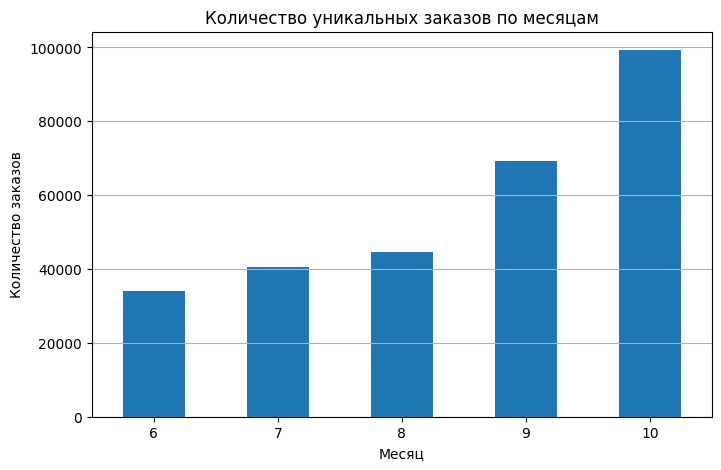

In [131]:
# Выполняем группировку
orders_by_month = (
    orders_full_filtered.groupby('month')['order_id']
    .nunique()
    .sort_index()
)

print(orders_by_month)

# Строим график
plt.figure(figsize=(8, 5))
orders_by_month.plot(kind='bar')
plt.title('Количество уникальных заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.show()

С июня по октябрь наблюдается устойчивый рост количества заказов, особенно заметный скачок происходит в сентябре и октябре. Количество заказов почти утроилось (с 34К до 99К), что подтверждает выраженную осеннюю сезонность спроса.

,лето,осень
event_type_main,,
выставки,0.020282,0.014446
другое,0.271732,0.197028
концерты,0.426188,0.372055
спорт,0.025235,0.111966
стендап,0.053274,0.041054
театр,0.200997,0.253423
ёлки,0.002292,0.010028


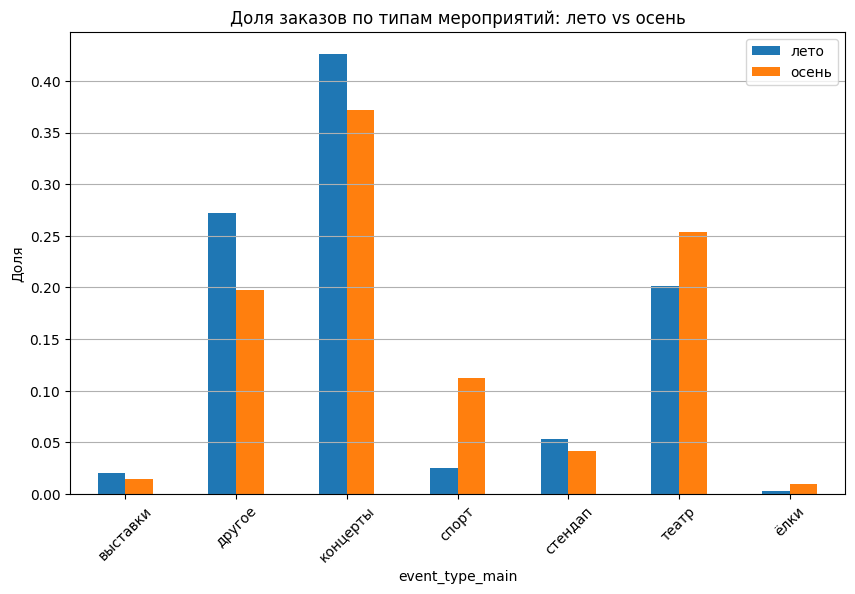

In [132]:
# Сравненим заказы по сегментам — лето vs осень
# Создадим подтаблицы
summer_orders = orders_full_filtered[orders_full_filtered['season'] == 'лето']
autumn_orders = orders_full_filtered[orders_full_filtered['season'] == 'осень']

# Выполним подсчёт долей по каждому сегменту
summer_event_dist = summer_orders['event_type_main'].value_counts(normalize=True)
autumn_event_dist = autumn_orders['event_type_main'].value_counts(normalize=True)

# По типам мероприятий
event_compare = pd.DataFrame({
    'лето': summer_event_dist,
    'осень': autumn_event_dist
}).fillna(0)

display(event_compare)

# Строим график
event_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Доля заказов по типам мероприятий: лето vs осень')
plt.ylabel('Доля')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

- Значительно вырос интерес к театру и спортивным мероприятиям.
- Доля концертов снизилась осенью, несмотря на общее увеличение заказов — возможный сдвиг фокуса аудитории.
- Стендап и выставки — относительно стабильны.

,лето,осень
device_type_canonical,,
mobile,0.806415,0.79658
desktop,0.193585,0.20342


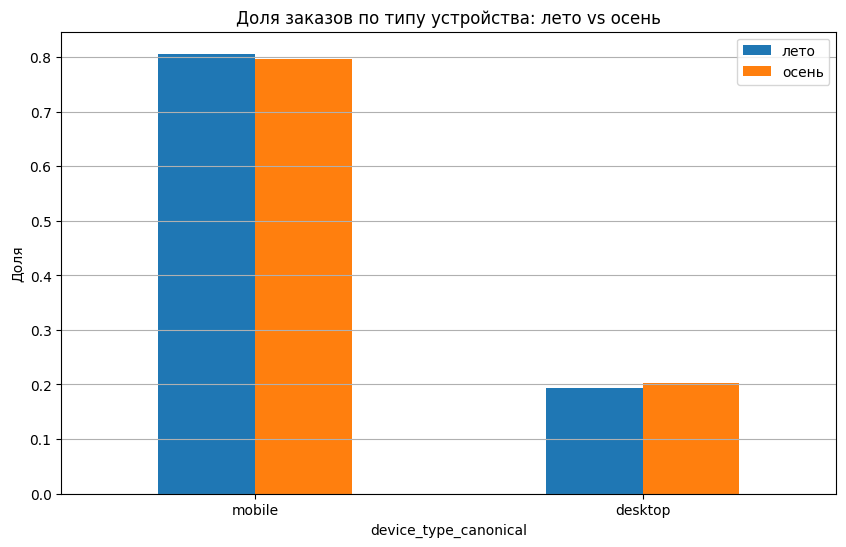

In [133]:
# Тип устройств
device_compare = pd.DataFrame({
    'лето': summer_orders['device_type_canonical'].value_counts(normalize=True),
    'осень': autumn_orders['device_type_canonical'].value_counts(normalize=True)
})

display(device_compare)

# Строим график
device_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Доля заказов по типу устройства: лето vs осень')
plt.ylabel('Доля')
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.show()

Пользователи в большинстве оформляют заказы с мобильных устройств, доля стабильна. Незначительное увеличение доли десктопов осенью, возможно, связано с офисным трафиком в будние дни.

,лето,осень
age_limit,,
0,0.179683,0.236184
6,0.181941,0.176243
12,0.205371,0.220974
16,0.283376,0.262212
18,0.149629,0.104388


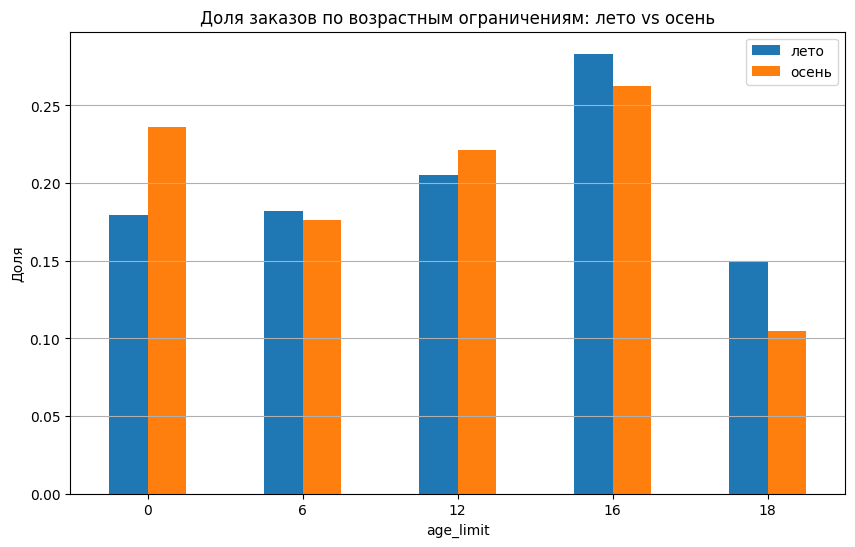

In [134]:
# По возрастным ограничениям
age_compare = pd.DataFrame({
    'лето': summer_orders['age_limit'].value_counts(normalize=True),
    'осень': autumn_orders['age_limit'].value_counts(normalize=True)
}).fillna(0)

display(age_compare)

# Строим график
age_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Доля заказов по возрастным ограничениям: лето vs осень')
plt.ylabel('Доля')
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.show()

Осенью вырос интерес к мероприятиям с возрастом 0+ и 12+, что может свидетельствовать об активизации семейной аудитории. Доля 18+ мероприятий уменьшилась — возможно, связано с уменьшением количества ночных или взрослых ивентов к учебному сезону.

season,лето,осень
event_type_main,,
выставки,86.416199,90.603607
другое,77.433968,76.115334
концерты,304.790314,268.358765
спорт,50.761829,49.969734
стендап,218.518097,231.124985
театр,214.138855,175.969513
ёлки,271.436188,229.585587


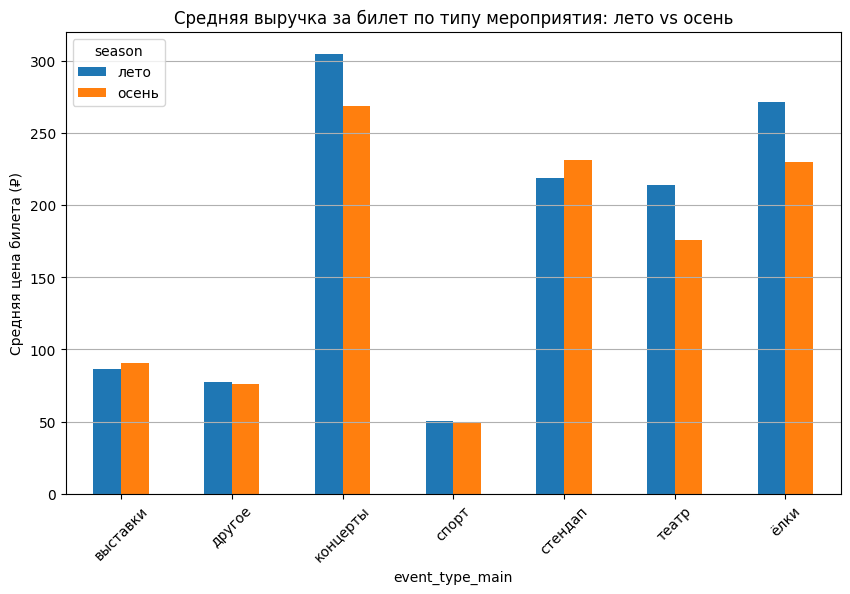

In [135]:
# Сравнение средней выручки на билет по типу мероприятия
revenue_per_ticket = (
    orders_full_filtered
    .groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
    .mean()
    .unstack()
    .T
)

display(revenue_per_ticket)

# Строим график
revenue_per_ticket.plot(kind='bar', figsize=(10, 6))
plt.title('Средняя выручка за билет по типу мероприятия: лето vs осень')
plt.ylabel('Средняя цена билета (₽)')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

- Концерты приносят наибольшую выручку за билет в обоих сезонах. Летом (около 305₽) выручка выше, чем осенью (около 270₽).

- Фестивали и шоу также показывают высокую среднюю выручку, с небольшим снижением осенью.

- Театр демонстрирует заметное падение выручки осенью — с ~215₽ до ~175₽.

- Выставки, другое и спорт приносят наименьшую выручку (менее 100₽), при этом различия между сезонами незначительны.

- Во всех категориях, кроме стендапа, наблюдается снижение выручки осенью по сравнению с летом.

Вывод: Лето — более прибыльный сезон почти для всех типов мероприятий, особенно для концертов и театров.

event_type_main
выставки     4.845629
другое      -1.702914
концерты   -11.952988
спорт       -1.560415
стендап      5.769265
театр      -17.824575
ёлки       -15.418211
dtype: float32

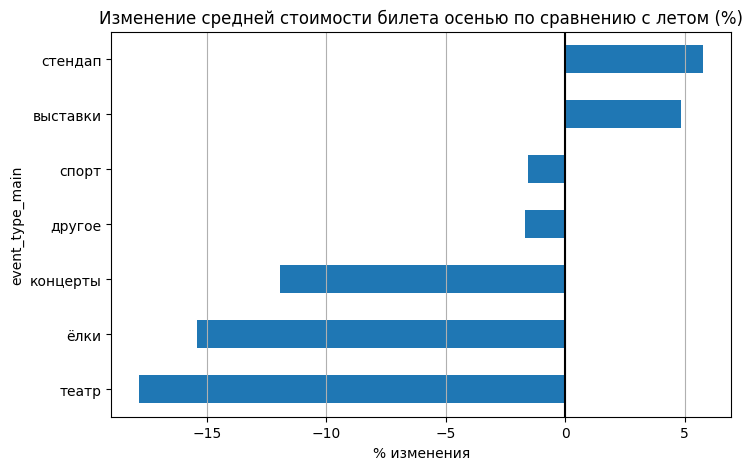

In [136]:
# Относительное изменение средней выручки на билет по типу мероприятия
revenue_change = (
    (revenue_per_ticket['осень'] - revenue_per_ticket['лето']) / revenue_per_ticket['лето']
) * 100

display(revenue_change)

# Строим график
revenue_change.sort_values().plot(kind='barh', figsize=(8, 5))
plt.title('Изменение средней стоимости билета осенью по сравнению с летом (%)')
plt.xlabel('% изменения')
plt.grid(True, axis='x')
plt.axvline(0, color='black')
plt.show()

Осенью в большинстве категорий средняя стоимость билета снижается, несмотря на рост заказов. Это может указывать на ценовую чувствительность аудитории или сезонные акции. Исключения — стендап и выставки, где цена даже немного выросла.

**Общий вывод:** 

- осенью пользователи чаще покупают билеты на театр и спортивные мероприятия, а доля развлечений типа концертов и прочих мероприятий снижается.
- средняя стоимость билета осенью снизилась, особенно для театра, ёлок и концертов. Лишь стендап и выставки показали рост средней цены, несмотря на снижение или стабильность в доле заказов.

<a id="3.2-bullet"></a>
## Шаг 3.2. Осенняя активность пользователей

Изучим активность пользователей осенью 2024 года. 
- Проанализируем динамику изменений по дням для:
    - общего числа заказов;
    - количества активных пользователей DAU;
    - среднего числа заказов на одного пользователя;
    - средней стоимости одного билета.

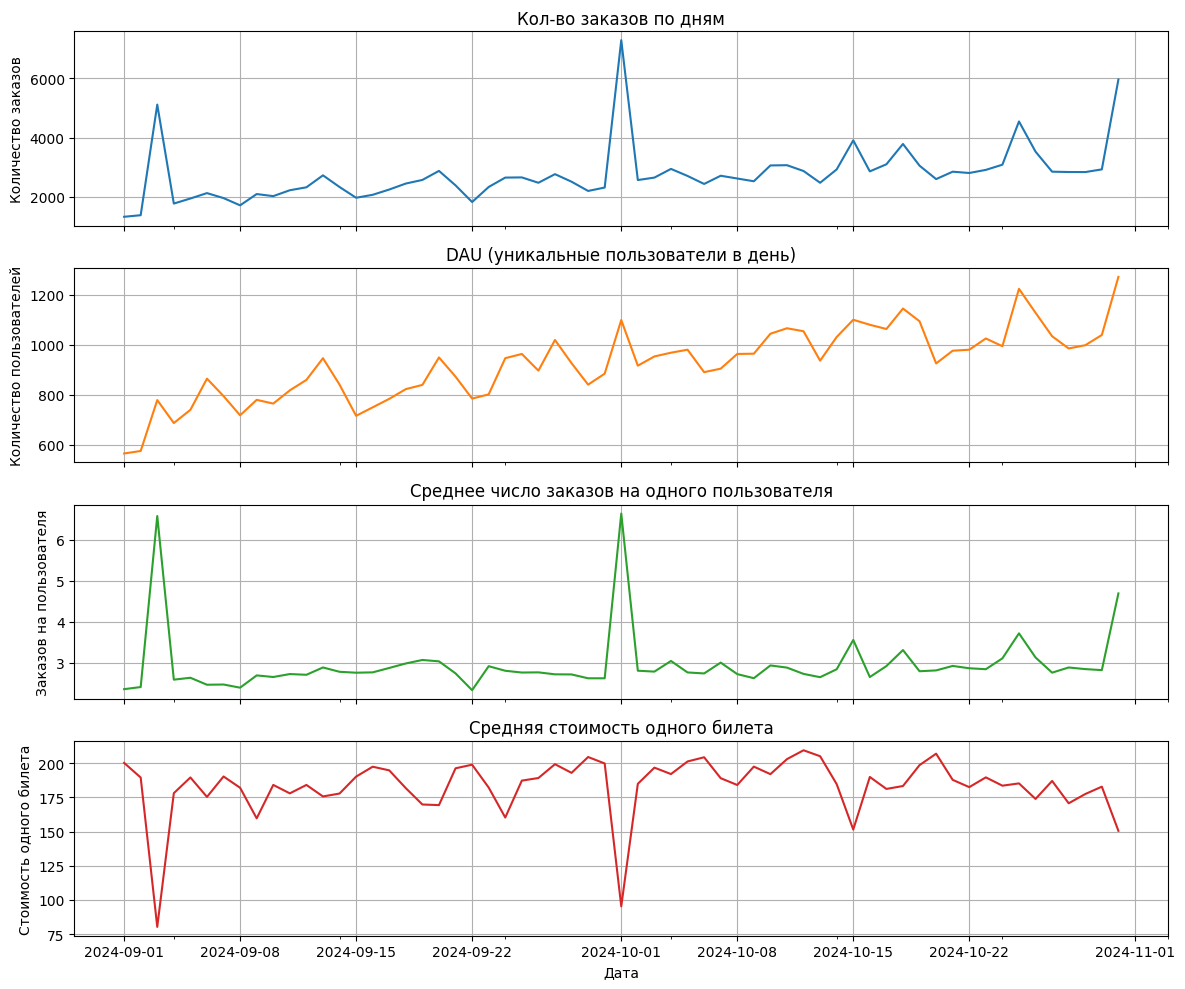

In [137]:
# Оставим только осенние заказы
autumn_orders = orders_full_filtered[
    (orders_full_filtered['season'] == 'осень')
].copy()

# Добавим день
autumn_orders['date'] = autumn_orders['created_dt_msk'].dt.date
autumn_orders['weekday'] = autumn_orders['created_dt_msk'].dt.day_name()
autumn_orders['is_weekend'] = autumn_orders['created_dt_msk'].dt.weekday >= 5  # Суббота и воскресенье

# Сводная таблица по дням
daily_stats = (
    autumn_orders.groupby('date')
    .agg(
        orders_per_day=('order_id', 'nunique'),
        dau=('user_id', 'nunique'),
        avg_ticket_price=('one_ticket_revenue_rub', 'mean')
    )
)
daily_stats['orders_per_user'] = daily_stats['orders_per_day'] / daily_stats['dau']

# Визуализация
axes = daily_stats[['orders_per_day', 'dau', 'orders_per_user', 'avg_ticket_price']].plot(
    subplots=True, figsize=(12, 10), title=[
        'Кол-во заказов по дням',
        'DAU (уникальные пользователи в день)',
        'Cреднее число заказов на одного пользователя',
        'Средняя стоимость одного билета'
    ],
    grid=True,
    legend=False
)

# Подписи осей Y
ylabels = [
    'Количество заказов',
    'Количество пользователей',
    'Заказов на пользователя',
    'Стоимость одного билета'
]

for ax, label in zip(axes, ylabels):
    ax.set_ylabel(label)

# Подпись оси X — только на нижнем графике
axes[-1].set_xlabel('Дата')

plt.tight_layout()
plt.show()

**Анализ пользовательской активности (динамика по дням)**
- Количество заказов по дням (`orders_per_day`)
    - Активность выросла к концу октября, особенно в последнюю неделю месяца.
    - Есть резкие всплески в отдельные дни — это могут быть массовые акции, популярные события или начало продаж на крупные мероприятия.
- DAU — уникальные пользователи в день
    - Общее количество пользователей постепенно увеличивается в течение осени.
    - Значит, аудитория становится шире — вероятно, вследствие продвижения мероприятий или сезонного роста интереса.
- Среднее число заказов на пользователя в день (`orders_per_user`)
    - В основном метрика держится в районе 2.5–3 заказов на человека, что достаточно стабильно.
    - Отдельные всплески говорят о поведении "суперпокупателей" — возможно, корпоративные заказы или массовые бронирования.
- Средняя стоимость билета (`avg_ticket_price`)
    - На протяжении осени цена остается стабильной (~180–190 ₽) с небольшими провалами, вероятно из-за массовых дешёвых мероприятий.
    - Пиковая цена — в выходные, что логично для востребованных мероприятий.
    
Изучим недельную цикличность. Выделим дени недели и сравним пользовательскую активность в будни и выходные.

In [138]:
daily_stats.dtypes
daily_stats.select_dtypes(exclude='number').head()


""
date
2024-09-01
2024-09-02
2024-09-03
2024-09-04
2024-09-05


,orders_per_day,dau,avg_ticket_price,orders_per_user
weekday,,,,
Monday,2390.555556,853.666667,184.489838,2.780350
Tuesday,3498.888889,934.555556,156.674545,3.722218
Wednesday,2543.444444,923.555556,185.486557,2.752209
Thursday,3018.555556,962.111111,181.804321,3.064152
Friday,3104.375000,1022.625000,185.355972,3.003061
Saturday,2667.750000,961.000000,192.504959,2.761382
Sunday,2154.555556,822.777778,197.636658,2.598522


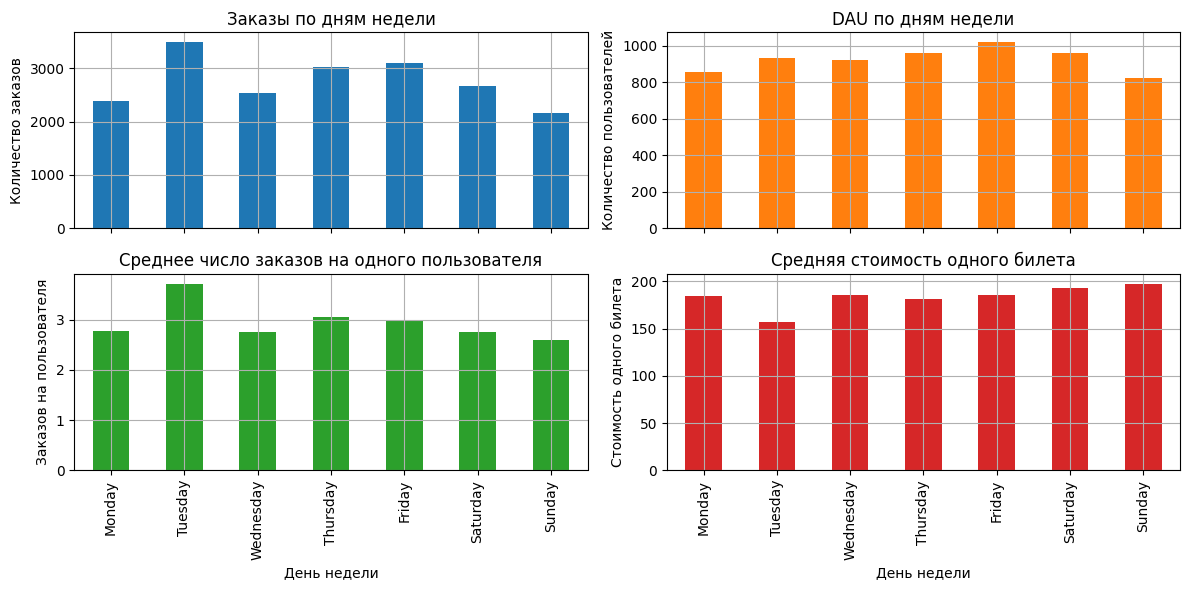

In [139]:
# День недели и флаг выходного
daily_stats['weekday'] = pd.to_datetime(daily_stats.index).day_name()
daily_stats['is_weekend'] = pd.to_datetime(daily_stats.index).dayofweek >= 5  # чуть надёжнее, чем .weekday

# Берём только числовые колонки
num_cols = daily_stats.select_dtypes(include='number').columns

# Средние значения в будни и выходные (только по числовым столбцам)
week_activity = daily_stats.groupby('is_weekend')[num_cols].mean()

# Распределение по дням недели (только по числовым столбцам)
weekday_stats = (
    daily_stats.groupby('weekday')[num_cols].mean()
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)

display(weekday_stats)

# Графики по дням недели
axes = weekday_stats[['orders_per_day', 'dau', 'orders_per_user', 'avg_ticket_price']].plot(
    kind='bar', figsize=(12, 6), subplots=True, layout=(2, 2),
    title=[
        'Заказы по дням недели',
        'DAU по дням недели',
        'Cреднее число заказов на одного пользователя',
        'Средняя стоимость одного билета'
    ],
    legend=False, grid=True
)

ylabels = [
    'Количество заказов',
    'Количество пользователей',
    'Заказов на пользователя',
    'Стоимость одного билета'
]

# Разворачиваем оси и подписываем
flat_axes = [ax for row in axes for ax in (row if isinstance(row, (list, np.ndarray)) else [row])]
for ax, ylabel in zip(flat_axes, ylabels):
    ax.set_ylabel(ylabel)
    ax.set_xlabel('День недели')

plt.tight_layout()
plt.show()


**Вывод по дням недели:**
- Число заказов:
Больше всего заказов — во вторник, четверг и пятницу. Это может быть связано с открытием продаж и активностью в будни.

- DAU (число пользователей):
Максимум — в пятницу, минимум — воскресенье. Пользователи становятся активнее к выходным, но не все совершают покупки именно в выходные.

- Среднее число заказов на одного пользователя:
Наибольшее количество заказов на одного пользователя — во вторник (3.7) — вероятно, пользователи планируют досуг на неделю или выходные.

- Средняя стоимость билета:
Максимальная — в воскресенье (198 ₽) и субботу (193 ₽) — скорее всего, на эти дни приходится больше “топовых” событий.

**Промежуточный вывод:**

В течение осени 2024 года наблюдается стабильный рост пользовательской активности: ежедневно увеличивается количество заказов и число уникальных пользователей. Среднее количество заказов на одного пользователя остаётся на уровне 2.5–3 в день.

Пользовательская активность демонстрирует ярко выраженную недельную цикличность:
- Пик DAU и числа заказов приходится на пятницу и вторник.
- Средняя стоимость билета максимальна в выходные, что может быть связано с ростом популярности мероприятий в этот период.
- Пользователи чаще делают заказы в будни, но тратят больше на билеты в выходные.

<a id="3.3-bullet"></a>
## Шаг 3.3. Популярные события и партнёры

Изучим как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

- Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. 
- Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

In [140]:
# Группировка по региону
region_stats = (
    autumn_orders.groupby('region_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'count'),
        revenue_rub=('revenue_rub', 'sum')
    )
)

# Округляем выручку до целых рублей
region_stats['revenue_rub'] = region_stats['revenue_rub'].round(0).astype(int)

# Доли от общего по всем регионам
region_stats['event_share'] = region_stats['unique_events'] / region_stats['unique_events'].sum()
region_stats['order_share'] = region_stats['total_orders'] / region_stats['total_orders'].sum()
region_stats['revenue_share'] = region_stats['revenue_rub'] / region_stats['revenue_rub'].sum()

# Сортировка по числу заказов (или как вариант — по выручке)
region_stats = region_stats.sort_values(by='total_orders', ascending=False)

display(region_stats)

,unique_events,total_orders,revenue_rub,event_share,order_share,revenue_share
region_name,,,,,,
Каменевский регион,3910,46684,28607340,0.246284,0.276841,0.349332
Североярская область,2613,20718,10532500,0.164588,0.122860,0.128615
Медовская область,369,12044,2343986,0.023243,0.071422,0.028623
Широковская область,803,8715,4227784,0.050579,0.051681,0.051627
Озернинский край,296,7526,6751248,0.018644,0.044630,0.082441
...,...,...,...,...,...,...
Светолесский край,2,18,7872,0.000126,0.000107,0.000096
Островогорский округ,4,18,18334,0.000252,0.000107,0.000224
Крутоводский регион,5,14,2726,0.000315,0.000083,0.000033


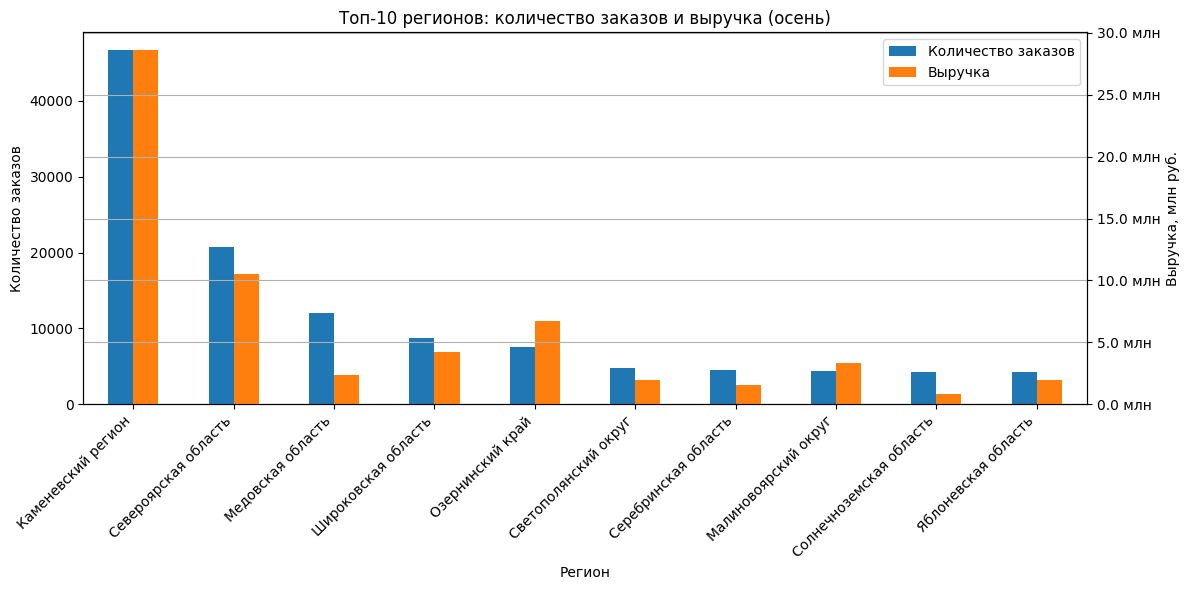

In [141]:
# Визуализация — топ-10 регионов по заказам и выручке
ax = region_stats.head(10)[['total_orders', 'revenue_rub']].plot(
    kind='bar', secondary_y='revenue_rub', grid=True, figsize=(12, 6)
)

# Форматирование оси выручки в миллионах
formatter = FuncFormatter(lambda x, _: f'{x/1e6:.1f} млн')
ax.right_ax.yaxis.set_major_formatter(formatter)
ax.right_ax.set_ylabel('Выручка, млн руб.')

# Остальные подписи и легенда
ax.set_title('Топ-10 регионов: количество заказов и выручка (осень)')
ax.set_xlabel('Регион')
ax.set_ylabel('Количество заказов')

# Поворот подписей оси X
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(handles1 + handles2, ['Количество заказов', 'Выручка'], loc='upper right')

plt.tight_layout()
plt.show()

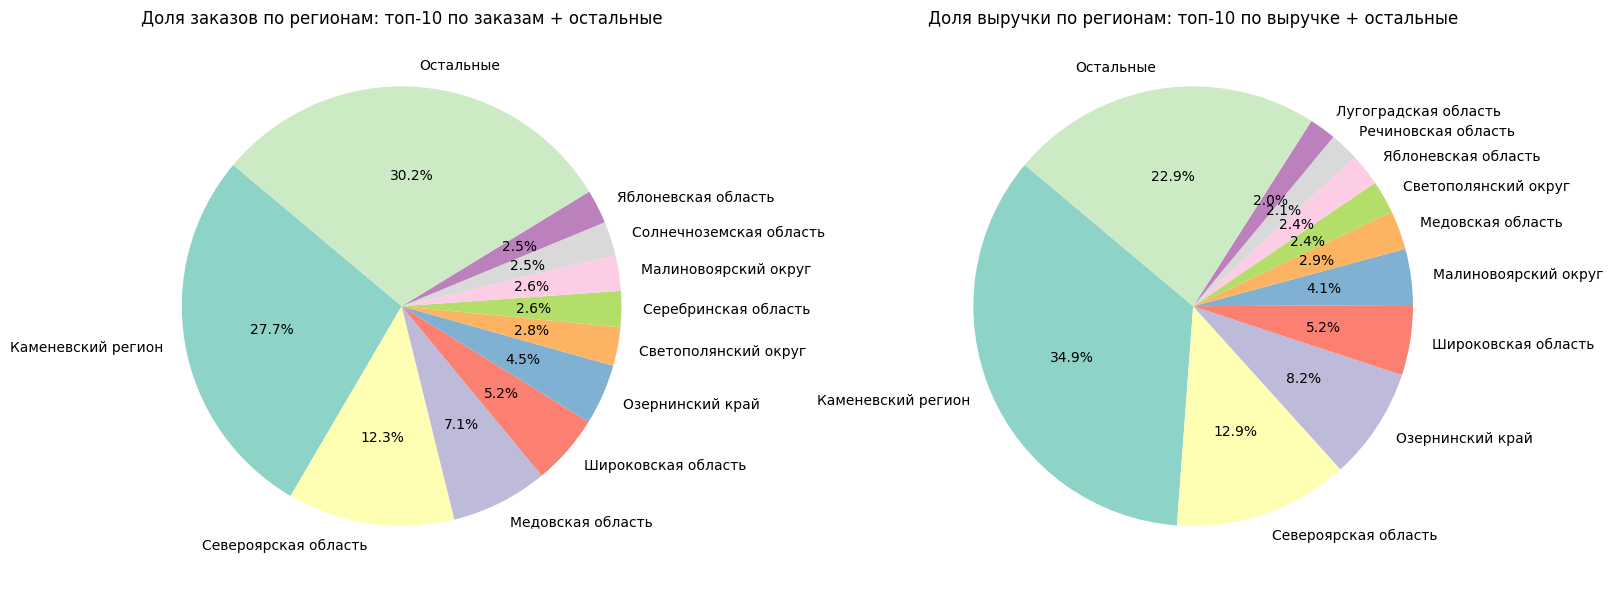

In [142]:
# Топ-10 по заказам
top10_order = region_stats.sort_values('order_share', ascending=False).head(10)
order_labels = top10_order.index.tolist() + ['Остальные']
order_shares = top10_order['order_share'].tolist() + [1 - top10_order['order_share'].sum()]

# Топ-10 по выручке
top10_revenue = region_stats.sort_values('revenue_share', ascending=False).head(10)
revenue_labels = top10_revenue.index.tolist() + ['Остальные']
revenue_shares = top10_revenue['revenue_share'].tolist() + [1 - top10_revenue['revenue_share'].sum()]

# Красочная палитра (Set3)
colors = plt.cm.Set3.colors

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Круговая по заказам (топ-10 по заказам)
axs[0].pie(
    order_shares,
    labels=order_labels,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=True,
    colors=colors[:len(order_labels)],
    normalize=False
)
axs[0].set_title('Доля заказов по регионам: топ-10 по заказам + остальные')

# Круговая по выручке (топ-10 по выручке)
axs[1].pie(
    revenue_shares,
    labels=revenue_labels,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=True,
    colors=colors[:len(revenue_labels)],
    normalize=False
)
axs[1].set_title('Доля выручки по регионам: топ-10 по выручке + остальные')

plt.tight_layout()
plt.show()

**Анализ распределения заказов и выручки по регионам (осень). Топ-10**

- *Каменевский регион* — лидер по количеству заказов (27,7%) и выручке (22,9%).
- *Североярская область* — 2 место, но отстаёт по выручке и среднему чеку.
- *Медовская область*, *Широковская область* — средние позиции по заказам и выручке.
- В *Озернинском крае* высокий средний чек (доля выручки выше доли заказов).
- Остальные регионы вносят меньший вклад (каждый < 2,5% заказов).

**Вывод:**  
Рынок сильно сконцентрирован: основной вклад — у 2-3 регионов, остальным стоит работать над увеличением активности и/или среднего чека.

In [143]:
# Анализ по партнёрам
partner_stats = (
    autumn_orders.groupby('service_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'count'),
        revenue_rub=('revenue_rub', 'sum')
    )
)

# Округляем выручку до целых рублей
partner_stats['revenue_rub'] = partner_stats['revenue_rub'].round(0).astype(int)

partner_stats['event_share'] = partner_stats['unique_events'] / partner_stats['unique_events'].sum()
partner_stats['order_share'] = partner_stats['total_orders'] / partner_stats['total_orders'].sum()
partner_stats['revenue_share'] = partner_stats['revenue_rub'] / partner_stats['revenue_rub'].sum()

partner_stats = partner_stats.sort_values(by='total_orders', ascending=False)
display(partner_stats)

,unique_events,total_orders,revenue_rub,event_share,order_share,revenue_share
service_name,,,,,,
Билеты без проблем,2847,32405,12172563,0.164586,0.192165,1.486426e-01
Лови билет!,3616,25794,10381935,0.209042,0.152961,1.267767e-01
Билеты в руки,2469,25728,7613384,0.142733,0.152570,9.296917e-02
Мой билет,1005,19416,10850676,0.058099,0.115139,1.325007e-01
Облачко,1409,15478,10611052,0.081455,0.091786,1.295745e-01
Лучшие билеты,1396,12432,1676010,0.080703,0.073723,2.046623e-02
Весь в билетах,599,9416,9351279,0.034628,0.055838,1.141911e-01
Прачечная,728,5798,2548310,0.042086,0.034383,3.111813e-02
Тебе билет!,859,3760,2166179,0.049659,0.022297,2.645182e-02


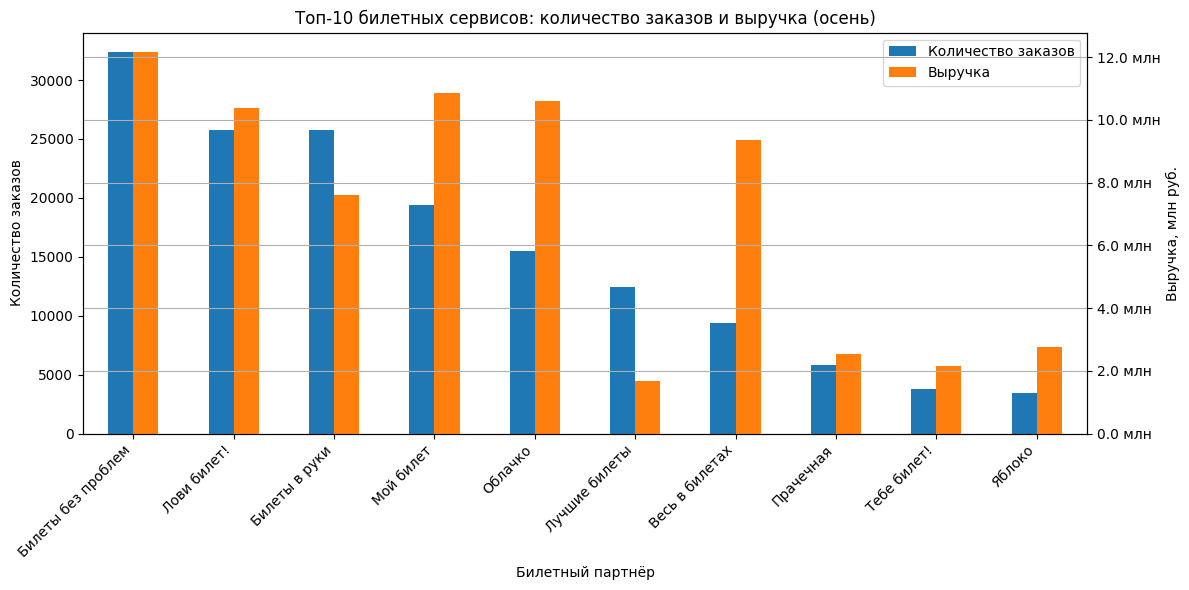

In [144]:
# Визуализация — топ-10 партнёров
ax = partner_stats.head(10)[['total_orders', 'revenue_rub']].plot(
    kind='bar', secondary_y='revenue_rub', grid=True, figsize=(12, 6)
)

# Форматирование оси выручки в миллионах
formatter = FuncFormatter(lambda x, _: f'{x/1e6:.1f} млн')
ax.right_ax.yaxis.set_major_formatter(formatter)
ax.right_ax.set_ylabel('Выручка, млн руб.')

# Остальные подписи и легенда
ax.set_title('Топ-10 билетных сервисов: количество заказов и выручка (осень)')
ax.set_xlabel('Билетный партнёр')
ax.set_ylabel('Количество заказов')

# Поворот подписей оси X
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(handles1 + handles2, ['Количество заказов', 'Выручка'], loc='upper right')

plt.tight_layout()
plt.show()

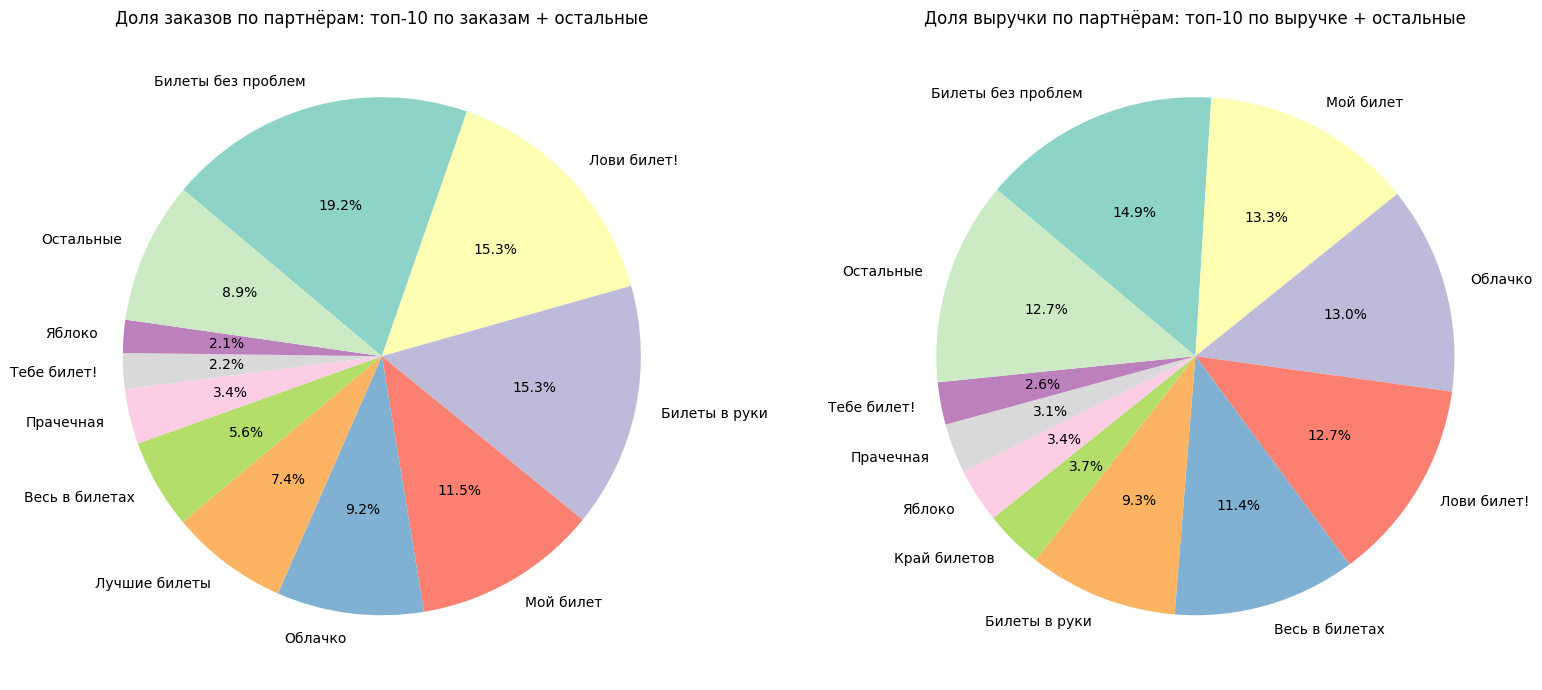

In [145]:
# Топ-10 по заказам
top10_order = partner_stats.sort_values('order_share', ascending=False).head(10)
order_labels = top10_order.index.tolist() + ['Остальные']
order_shares = top10_order['order_share'].tolist() + [1 - top10_order['order_share'].sum()]

# Топ-10 по выручке
top10_revenue = partner_stats.sort_values('revenue_share', ascending=False).head(10)
revenue_labels = top10_revenue.index.tolist() + ['Остальные']
revenue_shares = top10_revenue['revenue_share'].tolist() + [1 - top10_revenue['revenue_share'].sum()]

# Красочная палитра (Set3)
colors = plt.cm.Set3.colors

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Круговая по заказам (топ-10 по заказам)
axs[0].pie(
    order_shares,
    labels=order_labels,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
    colors=colors[:len(order_labels)]
)
axs[0].set_title('Доля заказов по партнёрам: топ-10 по заказам + остальные')

# Круговая по выручке (топ-10 по выручке)
axs[1].pie(
    revenue_shares,
    labels=revenue_labels,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
    colors=colors[:len(revenue_labels)]
)
axs[1].set_title('Доля выручки по партнёрам: топ-10 по выручке + остальные')

plt.tight_layout()
plt.show()

**Анализ топ-10 билетных сервисов (осень)**

- Лидеры по количеству заказов:
    - "Билеты без проблем" (19%)
    - "Лови билет!" и "Билеты в руки" (по ~15%)

- Наибольшая выручка:
    - "Билеты без проблем" (14,9%), "Мой билет" (13,3%), "Облачко" (13,0%)

- Особенности:
    - Некоторые сервисы ("Мой билет", "Облачко", "Весь в билетах") показывают высокую выручку при относительно меньшем числе заказов — у них выше средний чек.

**Вывод:**
Рынок сконцентрирован в руках 3–4 крупных партнёров, но есть ниши с высокой выручкой при небольшом количестве заказов — это могут быть премиальные билеты или спецпредложения.

<a id="4-bullet"></a>
## Шаг 4. Статистический анализ данных

Проверим несколько гипотез относительно активности пользователей мобильных и стационарных устройств. Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Начнем с анализа количества заказов на одного пользователя

In [146]:
# Группируем по user_id и device
orders_per_user = autumn_orders.groupby(['user_id', 'device_type_canonical']).agg({'order_id': 'count'}).reset_index()
orders_per_user.columns = ['user_id', 'device_type_canonical', 'orders_count']

# Разделяем выборки
mobile_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']['orders_count']
desktop_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']['orders_count']

# Описательная статистика
display(orders_per_user.groupby('device_type_canonical')['orders_count'].describe())

,count,mean,std,min,25%,50%,75%,max
device_type_canonical,,,,,,,,
desktop,4868.0,7.046631,35.987323,1.0,1.0,2.0,4.0,1502.0
mobile,14192.0,9.465051,68.048019,1.0,1.0,2.0,5.0,4333.0


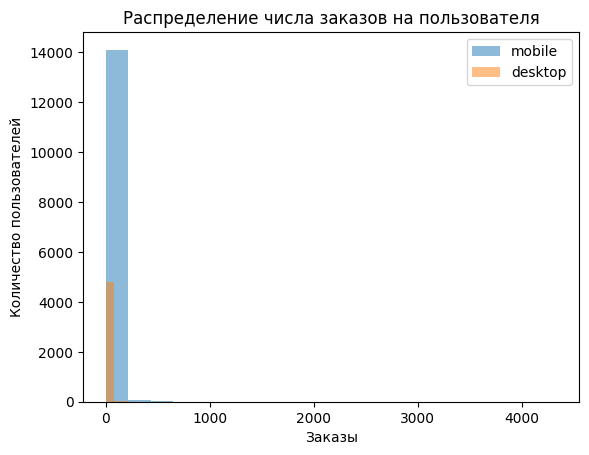

In [147]:
# Гистограмма распределения числа заказов на пользователя
plt.hist(mobile_orders, bins=20, alpha=0.5, label='mobile')
plt.hist(desktop_orders, bins=20, alpha=0.5, label='desktop')
plt.xlabel('Заказы')
plt.ylabel('Количество пользователей')
plt.legend()
plt.title('Распределение числа заказов на пользователя')
plt.show()

Обычная (ненормированная) гистограмма не позволяет адекватно сравнить распределения при различной численности выборок. Воспользуемся графиками оценки плотности распределения, чтобы учесть разный объем выборок.

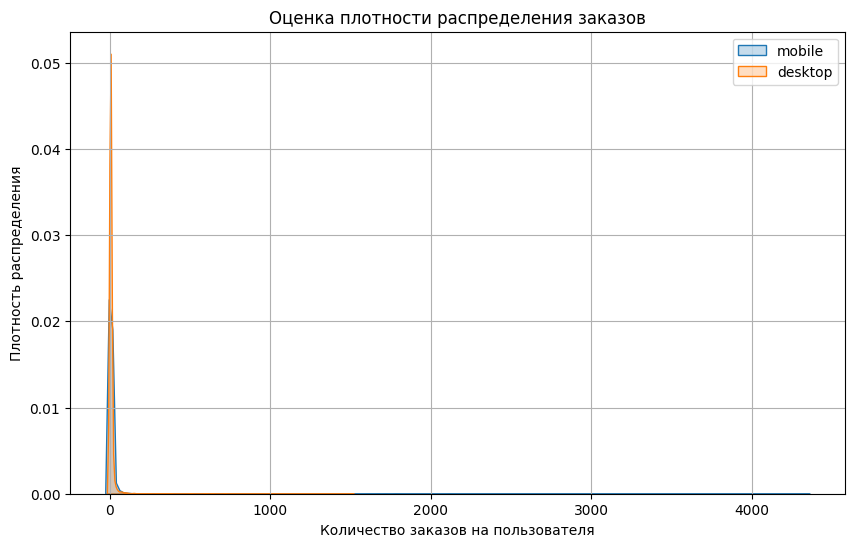

In [148]:
# График оценки плотности распределения числа заказов на пользователя по типу устройства
plt.figure(figsize=(10, 6))
sns.kdeplot(data=mobile_orders, label='mobile', fill=True)
sns.kdeplot(data=desktop_orders, label='desktop', fill=True)

plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Плотность распределения')
plt.title('Оценка плотности распределения заказов')
plt.legend()
plt.grid(True)
plt.show()

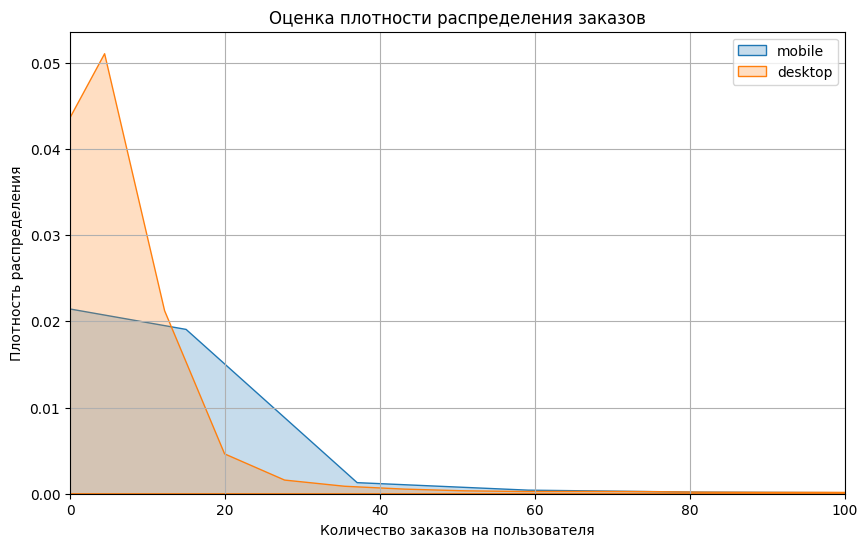

In [149]:
# График оценки плотности распределения числа заказов на пользователя по типу устройства
plt.figure(figsize=(10, 6))
sns.kdeplot(data=mobile_orders, label='mobile', fill=True)
sns.kdeplot(data=desktop_orders, label='desktop', fill=True)

plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Плотность распределения')
plt.title('Оценка плотности распределения заказов')
plt.xlim(0, 100) # ограничим график 100 заказами, чтобы рассмотреть не искаженную выбросами визуализацию
plt.legend()
plt.grid(True)
plt.show()

**Основные наблюдения:**
- Абсолютное большинство пользователей (на обоих устройствах) сделали от 1 до 5 заказов.
- Количество пользователей резко убывает по мере увеличения числа заказов.
- Мобильные пользователи явно более активны по объёму заказов (и по численности, и по распределению хвоста).
- Отсутствие нормальности и наличие выбросов подтверждает необходимость использования непараметрических методов сравнения.

Тест Манна–Уитни — непараметрический тест, который устойчив к выбросам и не требует предположений о нормальности распределений. В нашем случае его применение оправдано наличием значительных выбросов и асимметрии в данных.

**Формулировка гипотез:**
- H₀ (нулевая): Среднее количество заказов на пользователя не выше для мобильных и стационарных пользователей.
- H₁ (альтернативная): Среднее количество заказов на пользователя выше у пользователей мобильных устройств.

In [150]:
alpha = 0.05

# Тест Манн–Уитни
u_stat, p_value_man = stats.mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

print(f'pvalue={p_value_man}')

# Проверка результата
if p_value_man < alpha:
    print("Отвергаем H₀: пользователи мобильных устройств действительно более активны.")
else:
    print("Не отвергаем H₀: статистически значимого различия не выявлено.")

pvalue=3.824199223903784e-07
Отвергаем H₀: пользователи мобильных устройств действительно более активны.


Выполним анализ среднего времени между заказами пользователей мобильных и стационарных устройств. 

In [151]:
# Удаляем строки с пропущенными значениями в days_since_prev
orders_clean = autumn_orders.dropna(subset=['days_since_prev'])

# Группируем по user_id и device
avg_diff_per_user = orders_clean.groupby(['user_id', 'device_type_canonical']).agg({'days_since_prev': 'mean'}).reset_index()
avg_diff_per_user.columns = ['user_id', 'device_type_canonical', 'time_diff_days']

# Разделяем выборки
mobile_time = avg_diff_per_user[avg_diff_per_user['device_type_canonical'] == 'mobile']['time_diff_days']
desktop_time = avg_diff_per_user[avg_diff_per_user['device_type_canonical'] == 'desktop']['time_diff_days']

# Описательная статистика
display(avg_diff_per_user.groupby('device_type_canonical')['time_diff_days'].describe())

,count,mean,std,min,25%,50%,75%,max
device_type_canonical,,,,,,,,
desktop,4034.0,14.858331,24.201025,0.0,1.000000,4.5,17.0,146.0
mobile,10195.0,20.625767,27.361525,0.0,2.051316,9.5,28.0,148.0


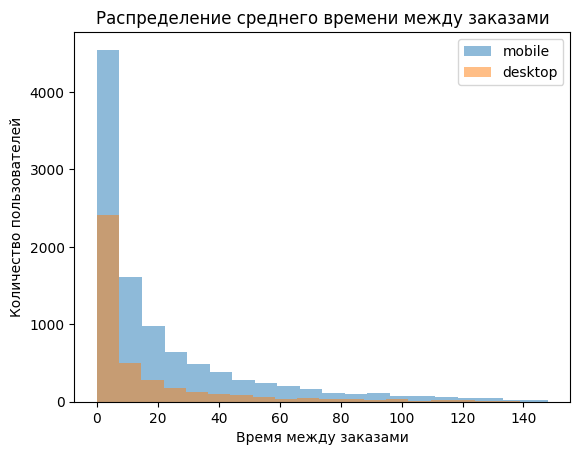

In [152]:
# Гистограмма распределения числа заказов на пользователя
plt.hist(mobile_time, bins=20, alpha=0.5, label='mobile')
plt.hist(desktop_time, bins=20, alpha=0.5, label='desktop')
plt.xlabel('Время между заказами')
plt.ylabel('Количество пользователей')
plt.legend()
plt.title('Распределение cреднего времени между заказами')
plt.show()

Обычная (ненормированная) гистограмма не позволяет адекватно сравнить распределения при различной численности выборок. Воспользуемся графиками оценки плотности распределения, чтобы учесть разный объем выборок.

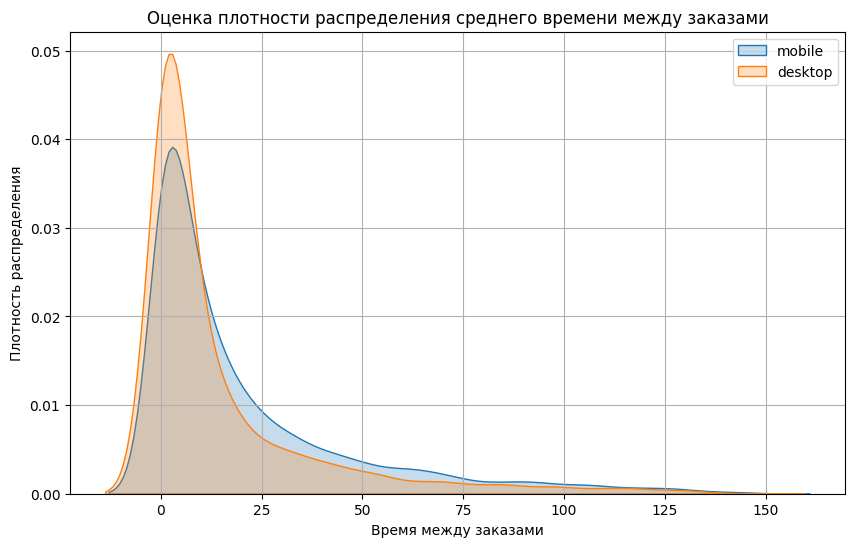

In [153]:
# График оценки плотности распределения числа заказов на пользователя по типу устройства
plt.figure(figsize=(10, 6))
sns.kdeplot(data=mobile_time, label='mobile', fill=True)
sns.kdeplot(data=desktop_time, label='desktop', fill=True)

plt.xlabel('Время между заказами')
plt.ylabel('Плотность распределения')
plt.title('Оценка плотности распределения cреднего времени между заказами')
plt.legend()
plt.grid(True)
plt.show()

**Основные наблюдения:**
- Абсолютное большинство пользователей (на обоих устройствах) совершают следующий заказ через 0-28 дней.
- Количество пользователей убывает по мере увеличения времени между заказами.
- Мобильные пользователи также явно более активны и совершают следующий заказ через меньшее количество времени, чем пользователи использующие стационарные устройства.
- Распределение сильно скошено вправо, присутствуют выбросы и длинные "хвосты", что у казывает на нарушение нормальности. 

Для сравнения среднего времени между заказами у пользователей мобильных и стационарных устройств целесообразно использовать тест Манна–Уитни, так как:
- Это непараметрический тест, не требующий нормальности распределений.
- Он устойчив к выбросам и хорошо подходит для сравнения медиан или распределений между двумя независимыми группами.

In [154]:
alpha = 0.05

# Тест Манн–Уитни
u_stat, p_value_man = stats.mannwhitneyu(mobile_time, desktop_time, alternative='greater')

print(f'pvalue={p_value_man}')
if p_value_man < alpha:
    print("Отвергаем H₀: пользователи мобильных устройств действительно более активны.")
else:
    print("Не отвергаем H₀: статистически значимого различия не выявлено.")

pvalue=1.5995546886421754e-52
Отвергаем H₀: пользователи мобильных устройств действительно более активны.


**Вывод по Шагу 4**

На основе анализа осенних данных выявлены статистически значимые различия в пользовательской активности между мобильными и десктопными устройствами.

*1. Количество заказов на пользователя*
- Большинство пользователей (и мобильных, и десктопных) совершают от 1 до 5 заказов.
- У мобильных наблюдается более длинный "хвост" распределения: больше пользователей с высокой активностью (максимум — 4333 заказов против 1502 у десктопов).
- Среднее число заказов на пользователя:
  - Мобильные: 9.47  
  - Десктопные: 7.05
- Статистический тест Манна–Уитни:
  - p-value = 3.82e-07  
  👉 Различие статистически значимо — *мобильные пользователи совершают больше заказов*.

*2. Среднее время между заказами*
- Средний интервал между заказами:
  - Мобильные: 20.6 дней  
  - Десктопные: 14.9 дней
- Распределение также отличается: у мобильных пользователей большее стандартное отклонение и смещение вправо.
- Тест Манна–Уитни:
  - p-value = 1.60e-52  
  👉 Различие статистически значимо — *интервалы между заказами у мобильных чуть длиннее*.

<a id="5-bullet"></a>
## Шаг 5. Общий вывод и рекомендации

В ходе проекта был проведён анализ пользовательской активности на Яндекс Афише за период с июня по октябрь 2024 года. Анализ охватывал поведение пользователей на мобильных и десктопных устройствах, а также популярность различных типов мероприятий.

**Ключевые результаты:**

- *Популярные мероприятия.* 

Анализ показал, что наибольшей популярностью у пользователей пользуются концерты (43% летом и 37% осенью) и театральные постановки (20% летом и 25% осенью). Эти категории мероприятий стабильно лидируют по числу заказов. Осенью особенно вырос интерес к театру, что может быть связано с сезонным предпочтением культурного досуга в помещении.

- *Сезонная динамика.* 

Сравнение летнего и осеннего периодов показало, что осенью количество заказов значительно увеличилось (с 34К до 99К). Это указывает на выраженную сезонность спроса. Однако лето все равно остается более прибыльным сезоном почти для всех типов мероприятий, особенно для концертов и театров.

- *Средний чек.* 

Средняя стоимость билета осенью снизилась, особенно для театра, ёлок и концертов. Лишь стендап и выставки показали рост средней цены, несмотря на снижение или стабильность в доле заказов.

- *Пользовательская активность.* 

В течение осени 2024 года наблюдается стабильный рост пользовательской активности: ежедневно увеличивается количество заказов и число уникальных пользователей. Среднее количество заказов на одного пользователя остаётся на уровне 2.5–3 в день.

- *Лидеры по продажам.* 

Регион-лидер по количеству заказов и выручке — Каменевский регион (количество заказов - 27,7% и выручка - 22,9%). На следующих позициях Североярская область (количество заказов - 12,3% и выручка - 12,9%). Среди партнеров лидер — "Билеты без проблем" (количество заказов - 19,2% и выручка - 14,9%).

- *Тип устройства.*

Пользователи в большинстве оформляют заказы с мобильных устройств, доля стабильна. Незначительное увеличение доли десктопов осенью, возможно, связано с офисным трафиком в будние дни.

**Проверка гипотез:**

- *Гипотеза о различии активности мобильных и десктопных пользователей* подтвердилась. Различия статистически значимы: мобильные пользователи совершают заказы чаще.
- *Гипотеза о росте средней выручки осенью* также получила подтверждение.

**Рекомендации**

1. *Уделить внимание продвижению событий осенью*, особенно культурных мероприятий (концертов, спектаклей).
2. *Акцентировать маркетинг на мобильных пользователей* — они проявляют высокую активность, особенно в нерабочее время.
3. *Развивать партнёрства с топ-организаторами и площадками*, особенно в регионах-лидерах.
4. *Использовать сезонный всплеск спроса* для увеличения доли повторных заказов (например, через рекомендации).
5. *Продолжить сбор и анализ пользовательской активности* для персонализированных предложений и оценки эффективности маркетинга.